In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from function_helper import correlations

In [8]:
sns.set_theme()

df = pd.read_parquet('data/rain_tots_plants_v2.parquet')
rain = pd.read_parquet('data/rain_v2.parquet')
prod = pd.read_parquet('data/prod_v2.parquet')
lots = pd.read_parquet('data/lots_v2.parquet')

## Exploratory data analysis - Rainfall

First I'll make a bar plot showing the mean rainfall totals across all years in each month with the standard error on each mean.

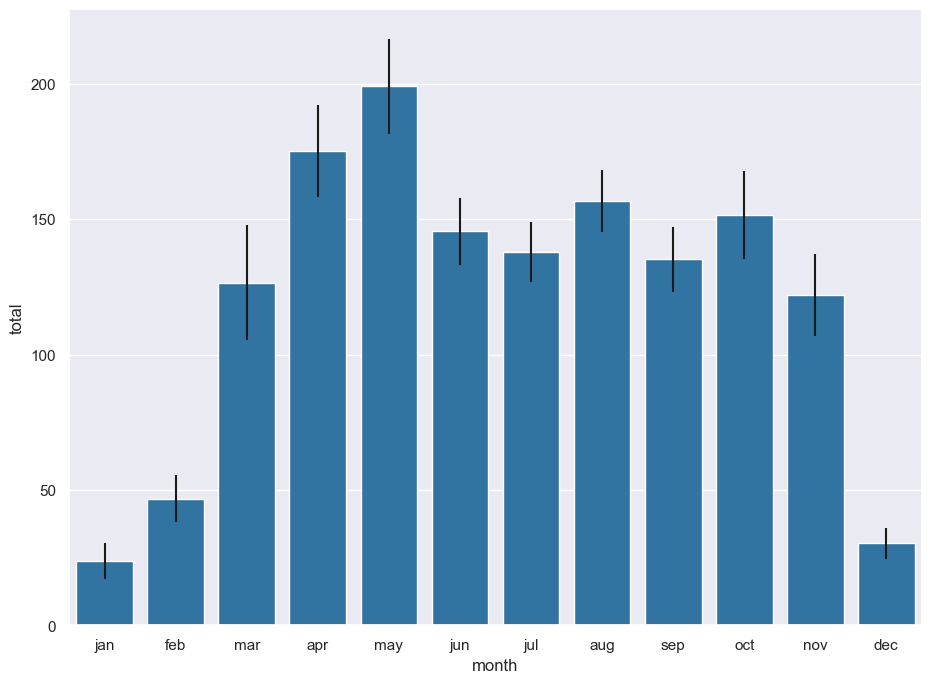

In [9]:
plt.figure(figsize=(11,8), dpi=100)
sns.barplot(y=rain.groupby('month')['total'].mean(), x=rain.groupby('month')['total'].mean().index, 
           order=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
           color='tab:blue',
           yerr=rain.groupby('month')['total'].sem());

We can see a clear wet-dry climate pattern where winter is dry, rainfall increases during March, peaks in May, and drops significantly again in December. 

Next I'll make a cluster map showing the correlations between parameters and hierarchical clusters in the data. For the hierarchical clustering I use a ward linkage method, which merges clusters that minimize the increase in cluster variance after merging.

<Figure size 3000x2400 with 0 Axes>

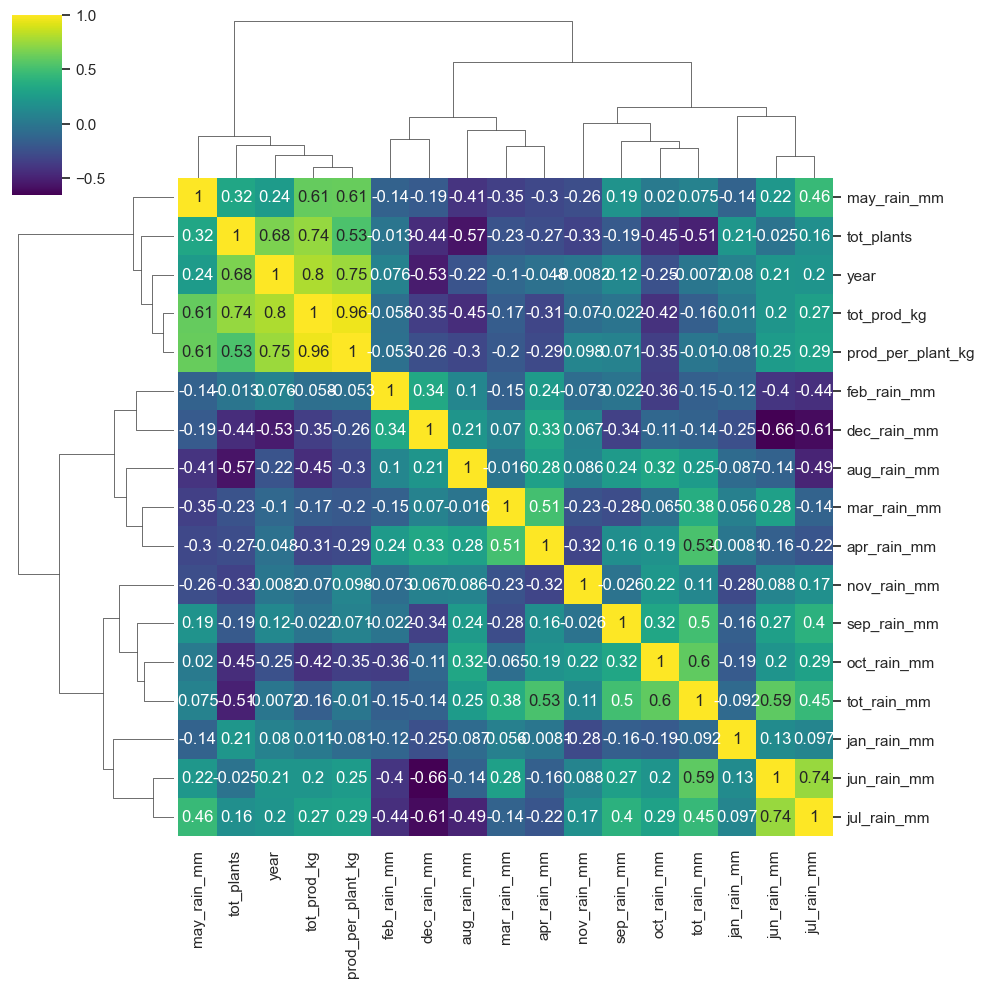

In [10]:
plt.figure(figsize=(15,12), dpi=200)
sns.clustermap(df.corr(), cmap='viridis', method='ward', annot=True);

We can see from the cluster map that there are three large scale groups or clusters in the data. The group with the highest correlation between features includes May rainfall, total plants, year, total production, and production per plant. The other two clusters contain only monthly rainfall totals. This suggests that May rainfall will be a useful predictor of production, which we will investigate further in the machine learning scripts. The total number of plants is also highly correlated with year, so we would expect production to increase with year, given the fact that having more plants result in a higher coffee production.

One of our main goals is to increase production, so we want to investigate which features correlates highly with it. Before investigating, let's engineer some new features that may possibly correlate highly with production. I'll make quarterly rainfall totals, half-year rainfall totals, and pairs of months.

In [11]:
df['q1_rain_mm'] = df.jan_rain_mm + df.feb_rain_mm + df.mar_rain_mm
df['q2_rain_mm'] = df.apr_rain_mm + df.may_rain_mm + df.jun_rain_mm
df['q3_rain_mm'] = df.jul_rain_mm + df.aug_rain_mm + df.sep_rain_mm
df['q4_rain_mm'] = df.oct_rain_mm + df.nov_rain_mm + df.dec_rain_mm

df['h1_rain_mm'] = df.jan_rain_mm + df.feb_rain_mm + df.mar_rain_mm + df.apr_rain_mm + df.may_rain_mm + df.jun_rain_mm
df['h2_rain_mm'] = df.jul_rain_mm + df.aug_rain_mm + df.sep_rain_mm + df.oct_rain_mm + df.nov_rain_mm + df.dec_rain_mm

df['p1_rain_mm'] = df.jan_rain_mm + df.feb_rain_mm
df['p2_rain_mm'] = df.mar_rain_mm + df.apr_rain_mm
df['p3_rain_mm'] = df.may_rain_mm + df.jun_rain_mm
df['p4_rain_mm'] = df.jul_rain_mm + df.aug_rain_mm
df['p5_rain_mm'] = df.sep_rain_mm + df.oct_rain_mm
df['p6_rain_mm'] = df.nov_rain_mm + df.dec_rain_mm

Next I'll calculate Pearson correlation coefficients with respect to total yearly production. I'll also report their p-values and significances.

In [13]:
stats = correlations(df)
stats

,pearson_corr,pval,is_significant
prod_per_plant_kg,0.956961,9.414941e-20,1.0
year,0.799194,1.151191e-13,1.0
tot_plants,0.738667,1.594723e-12,1.0
may_rain_mm,0.605169,4.187665e-07,1.0
p3_rain_mm,0.558862,6.682617e-05,1.0
q2_rain_mm,0.324266,6.143919e-02,0.0
jul_rain_mm,0.274594,3.140875e-02,1.0
jun_rain_mm,0.204311,1.518535e-01,0.0
h1_rain_mm,0.106702,7.229899e-01,0.0
jan_rain_mm,0.010792,3.070505e-01,0.0


Production per plant, year, total number of plants, May rainfall totals, and Period 3 rainfall totals are significantly correlated with yearly production, which is a similar result to what we saw in the cluster map. August, October, December, and April are anti-correlated with production. Naively one would not expect that you would have a higher crop production when there is less rainfall, but over-watering coffee plants is a concern. In years that have too much rainfall the plants under-produce. I will explore this further in the model_simulated_profitability and model_yearly_production scripts. We will see that May and October are critical months for predicting the production and whether a year is going to be profitable. The higher the May rainfally and the lower the October rainfally, the higher the production or probability of being a profitable year.

Let's plot individual correlations below.

In [15]:
# plt.figure(dpi=200)
# sns.scatterplot(data=df, x='p3_rain_mm', y='tot_prod_kg')

<AxesSubplot: xlabel='may_rain_mm', ylabel='tot_prod_kg'>

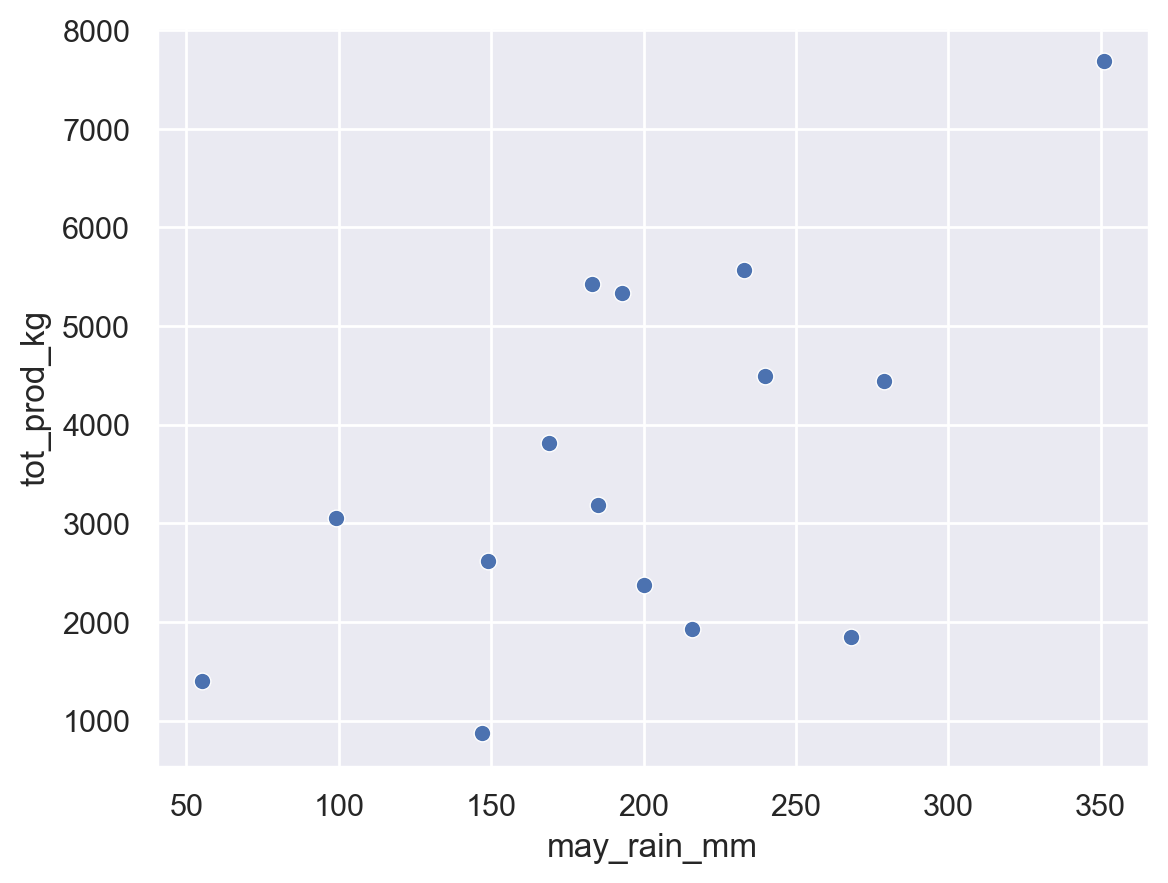

In [16]:
plt.figure(dpi=200)
sns.scatterplot(data=df, x='may_rain_mm', y='tot_prod_kg')

<AxesSubplot: xlabel='tot_plants', ylabel='tot_prod_kg'>

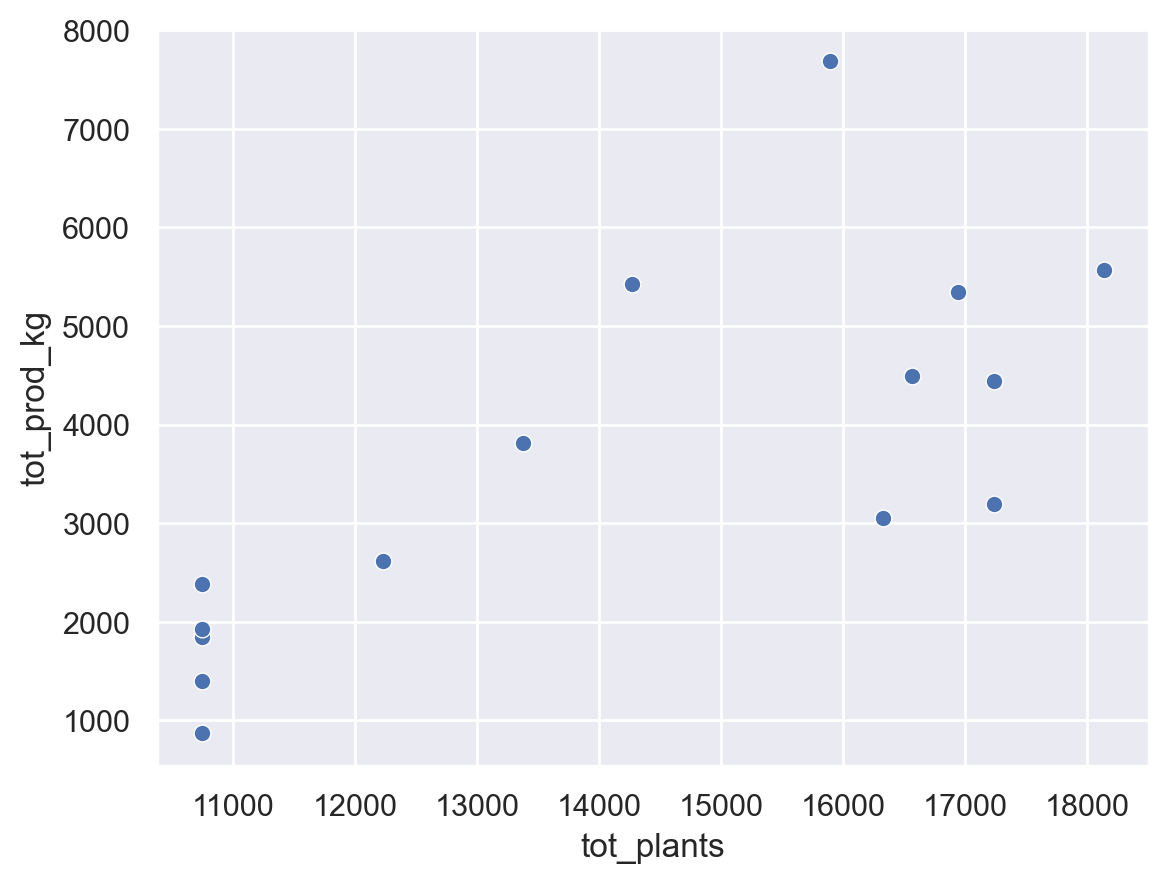

In [17]:
plt.figure(dpi=200)
sns.scatterplot(data=df, x='tot_plants', y='tot_prod_kg')

<AxesSubplot: xlabel='year', ylabel='tot_prod_kg'>

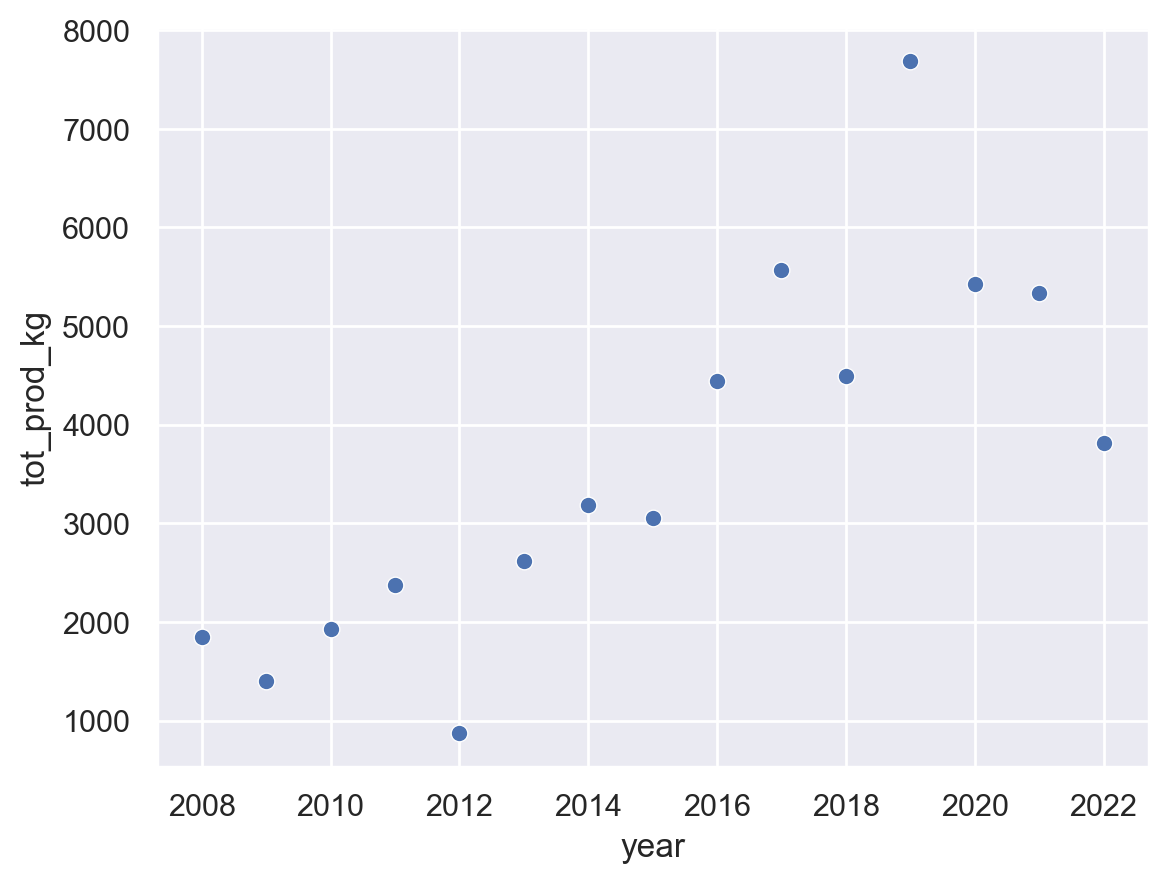

In [18]:
plt.figure(dpi=200)
sns.scatterplot(data=df, x='year', y='tot_prod_kg')

<AxesSubplot: xlabel='prod_per_plant_kg', ylabel='tot_prod_kg'>

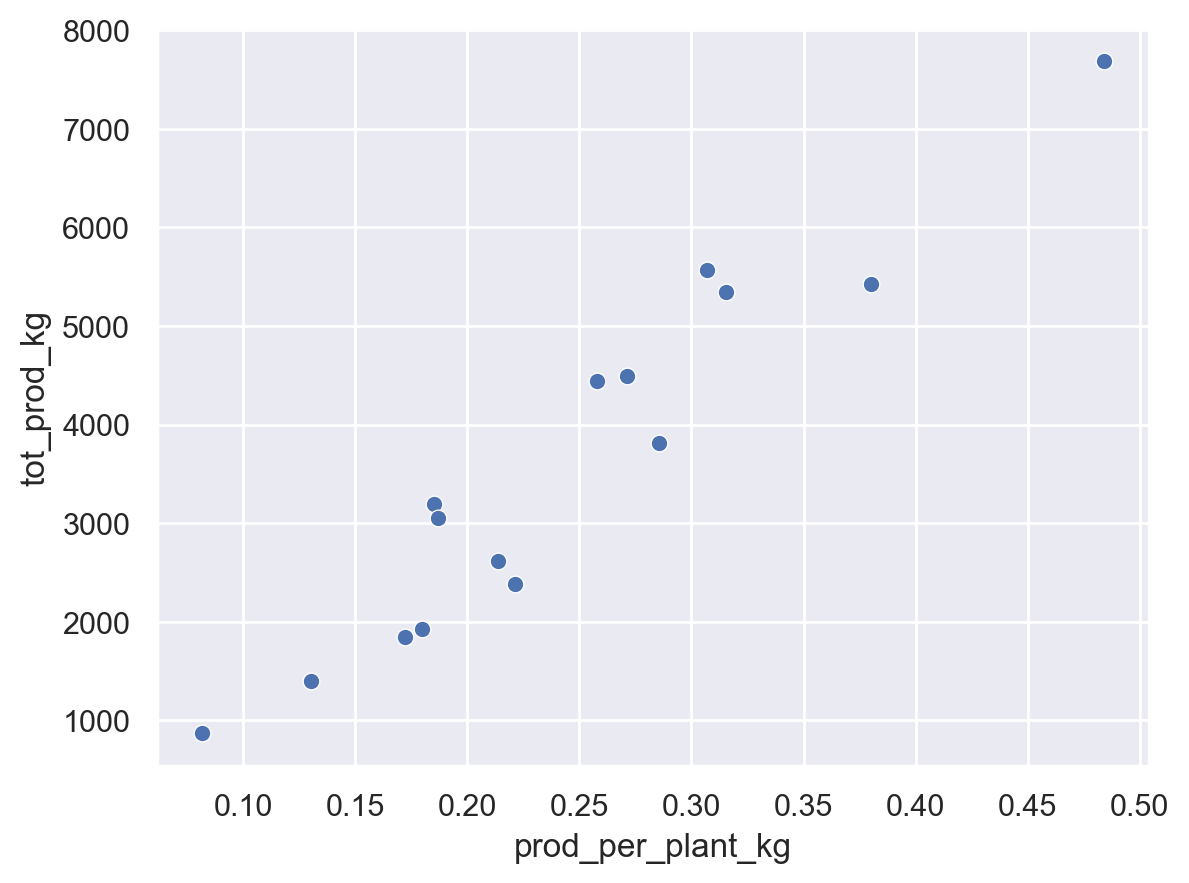

In [19]:
plt.figure(dpi=200)
sns.scatterplot(data=df, x='prod_per_plant_kg', y='tot_prod_kg')